# Dimensionality Reduction

Geochemical datasets often comprise dozens of variables, which can make dealing with the data overwhelming sometimes. Luckily, it is common that most observable variations can be explained by a smaller number of "latent" variables or processes. Dimensionality reduction methods are frequently applied to geochemical data in conjunction with other geological observations to try understand the main processes responsible for creating a certain feature.

It is also worth noting that dimensionality reduction might also be applied as a preliminary step in machine learning frameworks. By providing the model with more meaningful features training of the model is faster - less variables to deal with - and accuracy might be improved.

In this notebook we will follow an example based on [Soares et al. 2018](https://www.sciencedirect.com/science/article/pii/S0169136818300416?casa_token=yQPuWCGy4_4AAAAA:9nYGG7xC-JIOOxEZLiCPUR8LW0a4P7d438S9iZMOfzeg_gm7GqdIlsFWHd5ovBQzMkxizXJDlf4) to try to understand the mineralization prorcess in an orogenic gold deposit in central Brazil.

In [1]:
!pip install -q pyrolite | grep -v 'already satisfied'

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 13.3 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pyrolite.comp.codata import CLR
from sklearn.decomposition import PCA
import pyrolite.comp

import seaborn as sns

In [ ]:
Biq = pd.read_csv(r"https://raw.githubusercontent.com/pierosampaio/PythonWorkshop/main/MBS2018_Biquinho.csv")
Pim = pd.read_csv(r"https://raw.githubusercontent.com/pierosampaio/PythonWorkshop/main/MBS2018_Pimentao.csv", encoding='latin-1')

Biq = Biq.drop(columns=[col for col in Biq.columns if col.startswith('Unnamed')])
Pim = Pim.drop(columns=[col for col in Pim.columns if col.startswith('Unnamed')])

MBS = pd.concat([Biq, Pim])

columns = [
    'Au_ppb','Ag_ppm','As_ppm','Bi_ppm','Cr_ppm','Cu_ppm','Zn_ppm',
    'S_ppm','W_ppm','Co_ppm','Ni_ppm','Te_ppm','Tl_ppm','Ti_pct','Sb_ppm'
]

MBS = MBS[columns]

The Sao Sebastiao gold deposit is located in the NW sector of the Quadrilatero Ferrifero region of Brazil. The Meso-Neoarchean greenstone belts of the area host numerous orogenic gold deposits. The most important orogenies in the area are the 2.7 Ga Rio das Velhas orogeny and the 2.1 - 2.0 Ga Minas Orogeny (correlated to Transamazonian - Eburnean). Brasiliano-Pan-African affects the easternmost sector only. Most gold mineralization in the area is believed to be related to the post-orogenic stage of the Rio das Velhas orogeny.

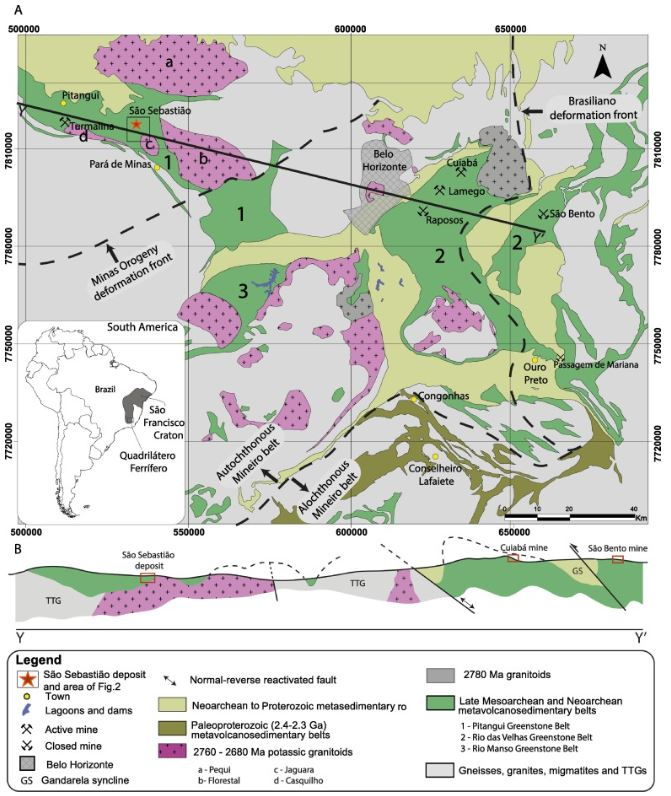


The deposit is hosted in BIFs of the Pitangui greenstone belt. The deposit lies close to the hinge of an anticline that was intruded by a 2.7 Ga TTG granitoid (Jaguara intrusion)

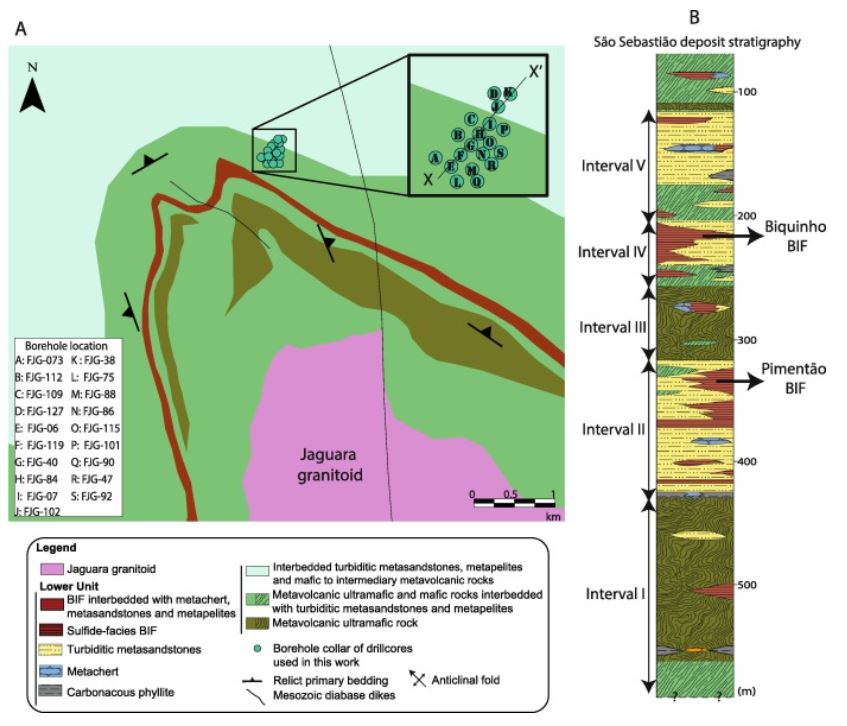

(Soares et al. 2018)

## Compositional data and log-ratio transformations

Logratio transformations are crucial for geochemical data analysis because such data are inherently compositional, meaning they represent parts of a whole and carry relative, rather than absolute, information. Direct analysis of raw geochemical data can lead to misleading interpretations due to the constant sum constraint, which induces spurious correlations among the variables. Logratio transformations, such as the additive logratio (alr), centered logratio (clr), and isometric logratio (ilr) transformations, address these issues by appropriately normalizing the data, allowing for meaningful multivariate statistical analyses. These transformations ensure that the inherent relationships and variability within the data are accurately captured, improving the robustness and interpretability of the results in geochemical studies.

In [ ]:
MBS_CLR = CLR(MBS.loc[:,'Au_ppb':]) # We're applying the Centered Logratio transform to all data


print(MBS_CLR)
print(f'Dimensions: {MBS_CLR.shape} - 512 observations and 15 variables')

[[ 5.1571646  -4.01693366  3.49340721 ... -3.82244537 -6.07956809
  -2.61383219]
 [ 2.29978303 -5.10199075  1.69110162 ... -3.89801795 -5.18900213
   2.47074083]
 [ 3.26890942 -4.88203938  2.84696309 ... -3.34159433 -4.45459536
  -1.86432819]
 ...
 [ 6.36555674 -1.94594154 -1.22637705 ... -3.94339592 -6.56106206
  -4.33543801]
 [ 5.67954487 -2.89201224  3.09906781 ... -3.2167646  -6.3092265
  -3.83479115]
 [ 5.89195587 -3.1284735   1.42579236 ... -3.50480023 -5.97443941
  -3.52030442]]
Dimensions: (512, 15) - 512 observations and 15 variables


For easier visualization of variables and their relations let's create a dataframe with the variable names and drop any rows that have no data.

In [ ]:
columns_clr = [ #Names of our columns
    'Au_clr','Ag_clr','As_clr','Bi_clr','Cr_clr','Cu_clr','Zn_clr',
    'S_clr','W_clr','Co_clr','Ni_clr','Te_clr','Tl_clr','Ti_clr','Sb_clr'
]
MBS_CLR = pd.DataFrame(
    dict(zip(columns_clr, MBS_CLR.T)) # Quickly creates a map from each column name to the appropriate data column in MBS_CLR
)

MBS_CLR = MBS_CLR.dropna() # Gets rid of rows with no data

In [ ]:
sns.pairplot(MBS_CLR) # This seaborn command lets us visualize pairwise combinations of variables
# It can be a bit overwhelming

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# A different option is to visualize the correlation matrix and color it according to the correlation
#coefficient

#MBS_CLR.corr().style.background_gradient(cmap='polar')

plt.figure(figsize=(10, 6))
sns.heatmap(MBS_CLR.corr(), annot=True, cmap='coolwarm_r', center=0)
plt.title('Heatmap of correlation table')
plt.xlabel('Principal Components')
plt.ylabel('Variables')
plt.show()

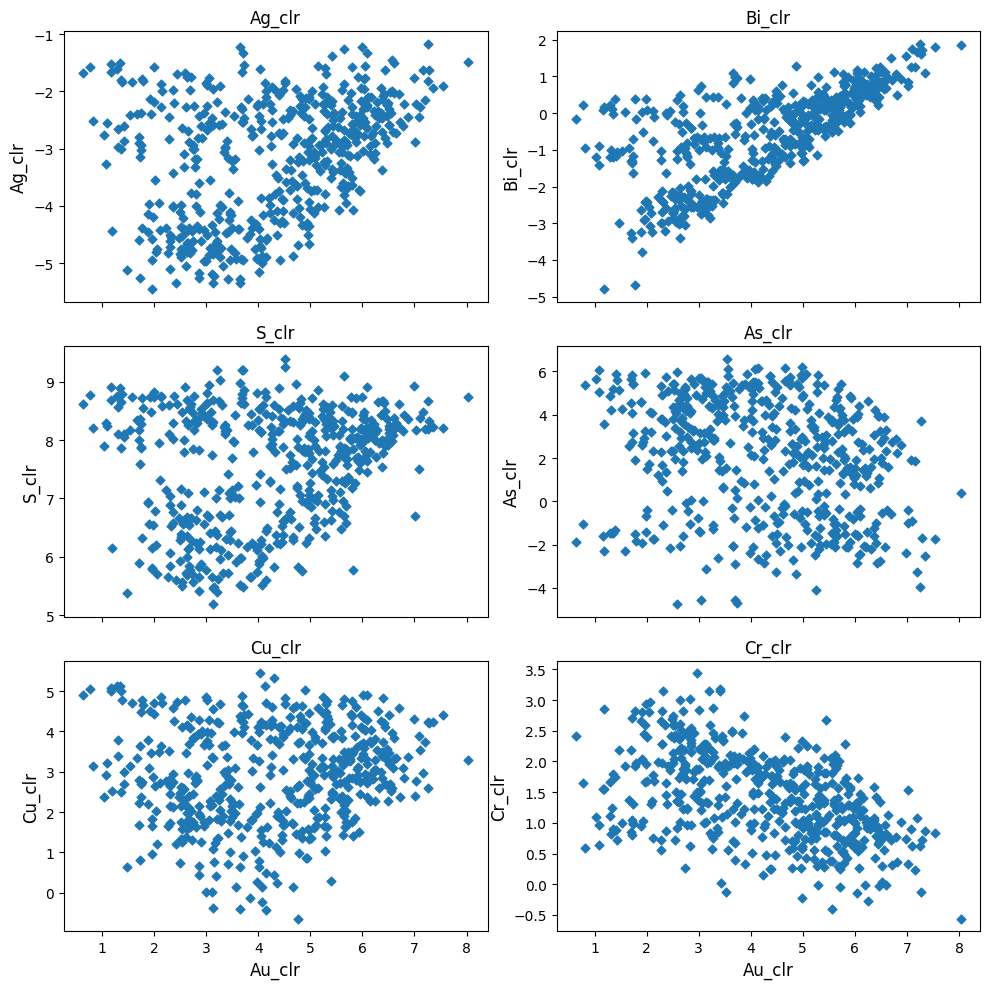

In [ ]:
fig, axes = plt.subplots(3,2,figsize=(10,10),sharex=True)
yax = ['Ag_clr','Bi_clr','S_clr','As_clr','Cu_clr','Cr_clr']

for el,ax in zip(yax,axes.flatten()):
    MBS_CLR.plot(kind='scatter',x='Au_clr',y=el,ax=ax)
    ax.set_title(el)

plt.tight_layout()

## Principal Component Analysis

While the application of the logratio transformation (in our case centered log ratio) solved the closeness problem of our data, we still have too many variables to process in an efficient and meaningful way.

Principal Component Analysis (PCA) is an essential tool for reducing the complexity of multivariate data and uncovering underlying patterns. By transforming original variables into a new set of uncorrelated variables called principal components, PCA highlights the most significant sources of variation within the dataset. This dimensionality reduction simplifies the data structure, making it easier to visualize and interpret. In geochemistry, PCA is widely used to identify geochemical signatures, distinguish between different geological processes, and correlate geochemical variables with environmental or geological factors.

A nice visual explanation of PCA can be found [here](https://bryanhanson.github.io/LearnPCA/articles/Vig_05_Visualizing_PCA_3D.html)


For PCA we can use the `sklearn.decomposition` module. We will create a PCA object and we will fit and transform our CLR-transformed data to create an MBS_PCA dataframe that will contain the values along each principal component for each one of our observations.

Remember: when creating the PCA object we cannot have more components than input observed variables.

In [ ]:
pca = PCA(n_components=10) # Large number of components
MBS_PCA = pca.fit_transform(MBS_CLR)
MBS_PCA.shape

(508, 10)

We can use the ["elbow method"](https://en.wikipedia.org/wiki/Elbow_method_(clustering)#:~:text=In%20cluster%20analysis%2C%20the%20elbow,number%20of%20clusters%20to%20use.) in this scree plot to estimate how many of the principal components are actually important

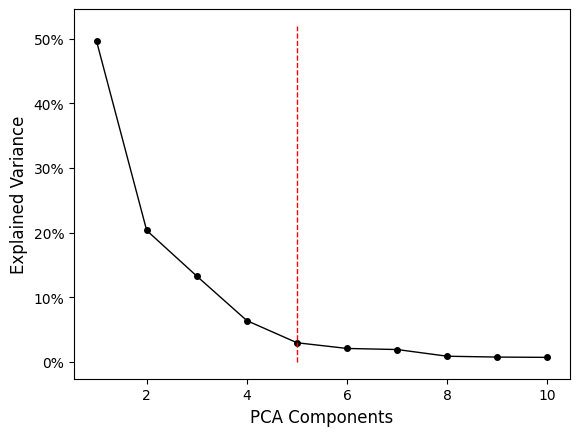

Explained variance for the first 5 PCs: 89.6%
Explained variance for the first 10 PCs: 99.0%


In [ ]:
plt.plot(
    np.arange(1,len(pca.explained_variance_ratio_)+1),
    pca.explained_variance_ratio_,
    marker='o',color='k'
)


plt.vlines(5,0,.52,linestyle='--',color='r')


plt.yticks(
    np.arange(0,0.51,0.1),
    labels=[f'{int(x*100)}%' for x in np.arange(0,0.51,0.1)]
)


plt.xlabel('PCA Components')
plt.ylabel('Explained Variance')

plt.show()

print(f'Explained variance for the first 5 PCs: {pca.explained_variance_ratio_[:4].sum()*100:.1f}%')
print(f'Explained variance for the first 10 PCs: {pca.explained_variance_ratio_.sum()*100:.1f}%')



From this we can see that after the 5th principal component, the other components explain very little of the remaining variability in the dataset

We can investigate the weight (loading) that every input variable has on all of the principal components

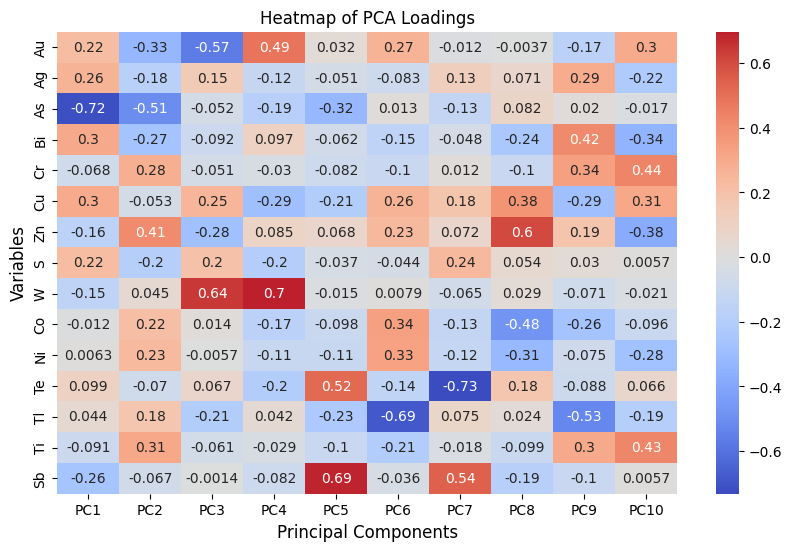

In [ ]:
loadings = pca.components_.T
variable_labels = [el.split('_')[0] for el in MBS_CLR.columns]
pc_labels = [f'PC{i+1}' for i in range(loadings.shape[1])]

loadings_df = pd.DataFrame(loadings, index=variable_labels, columns=pc_labels)

# Plot the heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(loadings_df, annot=True, cmap='coolwarm_r', center=0)
plt.title('Heatmap of PCA Loadings')
plt.xlabel('Principal Components')
plt.ylabel('Variables')
plt.show()

Let's see how the data is distributed with regards to the PCs

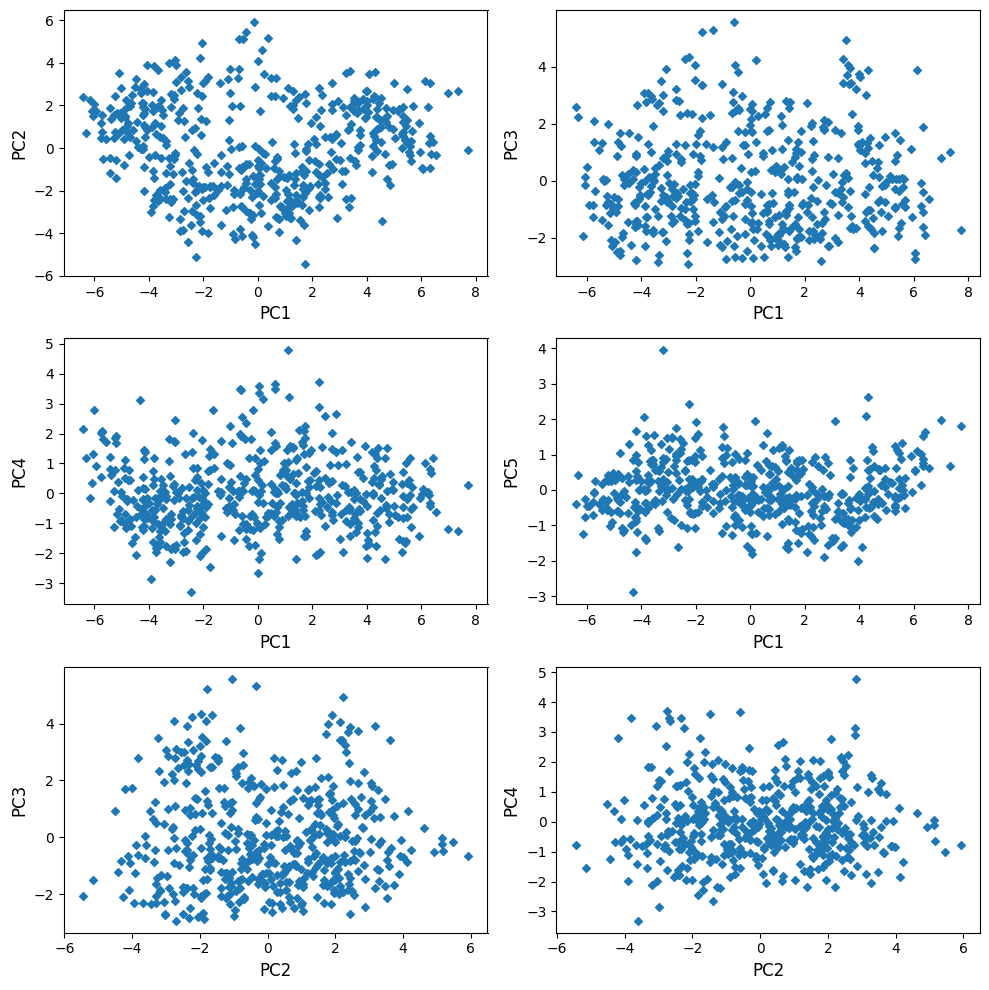

In [ ]:
fig, axes = plt.subplots(3,2,figsize=(10,10))

axes[0,0].scatter(
    MBS_PCA[:,0],MBS_PCA[:,1]
)
axes[0,0].set(xlabel='PC1',ylabel='PC2')


axes[0,1].scatter(
    MBS_PCA[:,0],MBS_PCA[:,2]
)
axes[0,1].set(xlabel='PC1',ylabel='PC3')


axes[1,0].scatter(
    MBS_PCA[:,0],MBS_PCA[:,3]
)
axes[1,0].set(xlabel='PC1',ylabel='PC4')


axes[1,1].scatter(
    MBS_PCA[:,0],MBS_PCA[:,4]
)
axes[1,1].set(xlabel='PC1',ylabel='PC5')


axes[2,0].scatter(
    MBS_PCA[:,1],MBS_PCA[:,2]
)
axes[2,0].set(xlabel='PC2',ylabel='PC3')


axes[2,1].scatter(
    MBS_PCA[:,1],MBS_PCA[:,3]
)
axes[2,1].set(xlabel='PC2',ylabel='PC4')

plt.tight_layout()



In the cell below we will define a function to plot the scatterpoints and arrows that point in the direction which element points to relative to the principal components. The length of the arrow will reflect the influence of that element on the PC, as seen in the PC loadings table.

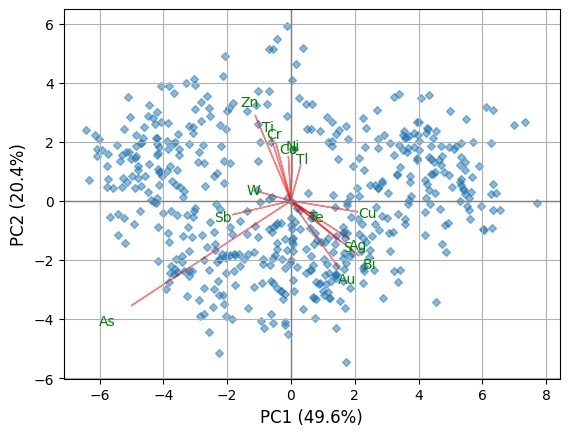

In [ ]:
def biplot(scores, loadings, labels=None, scale=7,ax=ax):

    ax.axhline(0, color='grey', lw=1)
    ax.axvline(0, color='grey', lw=1)
    ax.scatter(scores[:, 0], scores[:, 1], alpha=0.5)

    for i in range(loadings.shape[0]):
        ax.arrow(0, 0, scale*loadings[i, 0], scale*loadings[i, 1], color='r', alpha=0.5)
        if labels is None:
            ax.text(scale*loadings[i, 0] * 1.15, scale*loadings[i, 1] * 1.15, "Var"+str(i+1), color='g', ha='center', va='center')
        else:
            ax.text(scale*loadings[i, 0] * 1.15, scale*loadings[i, 1] * 1.15, labels[i], color='g', ha='center', va='center')

    ax.set_xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)")
    ax.set_ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)")
    ax.grid()

fig,ax = plt.subplots()
# Plot the biplot
biplot(MBS_PCA, pca.components_.T, labels=[el.split('_')[0] for el in MBS_CLR.columns],ax=ax)

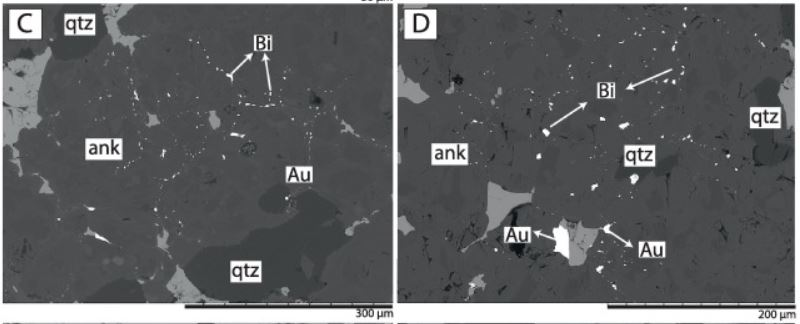

(Soares et al. 2018)

Correlation between Bi and Au is texturally coherent. Native Au and Bi are often found in association with Bi and Te sulfosalts, as well as ISS, a solid solution of Cu-Fe-S that forms by HT breakdown of chalcopyrite. Textural and mineralogical evidence point to presence of sulfide melts that scavenged gold and upgraded the deposit.

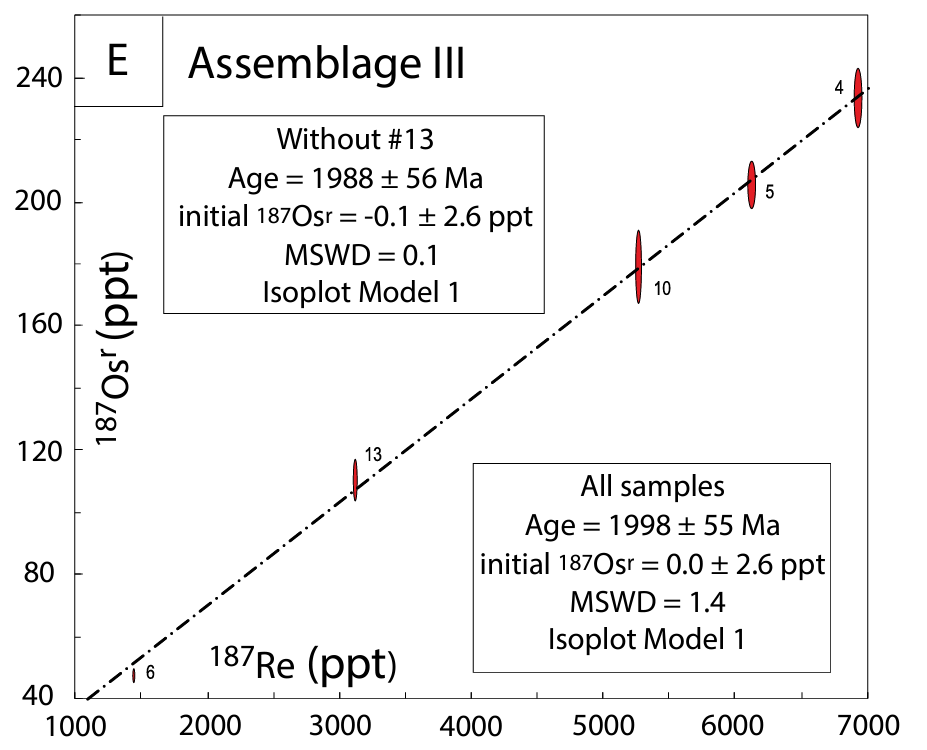

(Soares et al. 2021)

This late-stage assemblage that was identified as reflecting the most important stage of gold mineralization with the help of PCA was later dated at ~2.0 Ga [(Soares et al. 2021)](https://pubs.geoscienceworld.org/segweb/economicgeology/article/116/6/1455/595368/SULFIDE-RECRYSTALLIZATION-AND-GOLD-REMOBILIZATION?casa_token=Nf-kXwZSeSQAAAAA:wsAol23AoSq5i2zMGUjr8NeXqzfbv9mmHnTrjl_Sb9w1zxEQgeR5y0yUvQyM_lv9wFLwQpBJCKM) - that is, related to the Paleoproterozoic orogen, rather than the Archean orogen that caused gold mineralization in other deposits of the region.